## Tarea 1 - Beer Clustering
### Reconocimiento de patrones en Minería de Datos

Para esta tarea se realizara la implementación de los algoritmos de clustering: *K-means, Minibatch K-means, HAC Complete,Ward y DBSCAN* para el análisis de las reseñas obtenidos de la página beeradvocate la cual consta de un poco más de un millón y medio de datos como el dataset de prueba de los algoritmos, en los cuales se estudiará los valores de entrada de cada uno para obtener los clusters más adecuados.

# Caracterización del dataset
El data set consta de 13 atributos los cuales son:

<table class="tg">
  <tr>
    <th class="tg-yw4l">Nombre atributo</th>
    <th class="tg-yw4l">Tipo<br></th>
  </tr>
  <tr>
    <td class="tg-yw4l">brewery_id</td>
    <td class="tg-yw4l">int64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">brewery_name</td>
    <td class="tg-yw4l">object</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_time</td>
    <td class="tg-yw4l">int64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_overall</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_aroma</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_appearance</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_profilename</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_style</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_palate</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_taste</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_name</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_abv</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_beerid</td>
    <td class="tg-yw4l">int64</td>
  </tr>
</table>


De los cuales los pares beer_name y beer_beerid con brewery_id y brewery_name son equivalentes entre si y son del tipo de atributo que sirven para etiquetar.El atributo de tiempo de la reseña no se utilizó en el proceso de clustering ya que no es relevante para el análisis el día en que una persona realizó la reseña, al igual que el nombre de la persona.

Con lo que la dimensión real del dataset puede ser reducida a 9 atributos que son representativos en torno al sabor/gusto de la cerveza por el cliente y el lugar donde la bebió.

Antes de aplicar los algoritmos de clustering, se hace un preprocesamiento de los datos.En esta tarea se guarda un arreglo con 5000 reseñas, se trabaja con este número ya que es el que mejor trabaja en todos los algoritmos(parecido a un "mínimo común múltiplo") y por limitaciones de los recursos computacionales(aparecen errores de memoria en la ejecución por la gran cantidad de datos).



In [2]:
import numpy as np
import pandas as pn
import scipy
from sklearn import manifold
import matplotlib.pyplot as plt
import sklearn
beer_reviews  = pn.read_csv('beer_reviews/beer_reviews.csv',na_values=[''])
beer_reviews = beer_reviews.sample(n=5000)
beer_reviews = beer_reviews.fillna(method='ffill')
print (beer_reviews.shape)

(5000, 13)


En esta celda se lee el archivo *.csv* con todas las reseñas y se toma una muestra de 5000 datos al azar, se rellena con 0 en caso de que un campo de estos datos esté vacío. 

In [31]:
from sklearn import preprocessing
from sklearn import decomposition
le = preprocessing.LabelEncoder()

beer_rev=beer_reviews[['review_overall','review_aroma','review_appearance',
                       'review_palate','review_taste','beer_abv',
                       'beer_style',
                       'brewery_id'
                      ]]

#Estandarización de los datos
beer_r = beer_rev.copy()
le.fit(beer_r['beer_style'])
beer_r['brewery_id'] = preprocessing.scale(beer_r['review_overall'].astype(np.float64))
beer_r['beer_style'] = le.transform(beer_r['beer_style'])
beer_r['review_overall'] = preprocessing.scale(beer_r['review_overall'].astype(np.float64))
beer_r['review_aroma'] = preprocessing.scale(beer_r['review_aroma'].astype(np.float))
beer_r['review_appearance'] = preprocessing.scale(beer_r['review_appearance'].astype(np.float))
beer_r['review_palate'] = preprocessing.scale(beer_r['review_palate'].astype(np.float))
beer_r['review_taste'] = preprocessing.scale(beer_r['review_taste'].astype(np.float))
beer_r['beer_abv'] = preprocessing.scale(beer_r['beer_abv'].astype(np.float))
beer_r['brewery_id'] = preprocessing.scale(beer_r['brewery_id'].astype(np.float64))
pca = decomposition.PCA()
pca.n_components = 2
beer_red = pca.fit_transform(beer_r)

Se preprocesa los 9 atributos, teniendo en cuenta de que se decodifica el estilo de cerveza a un tipo numerico, luego para poder graficar, se hace una reducción de dimensionalidad a la matriz mediante PCA para dejarla en 2 componentes. Ahora se aplican los distintos algoritmos de cluster: 

**K-Means**

K-Means es un método de clustering que tiene como objetivo particionar n mediciones de un conjunto en k grupos en la que cada observación pertenece al grupo cuyo centroide es más cercano dentro de la distribución de los datos.La dificultad de este algoritmo es que como parámetro se le entrega el número de clusters 'K', pero a priori no se sabe la distribución de los datos y si este 'K' es el óptimo.

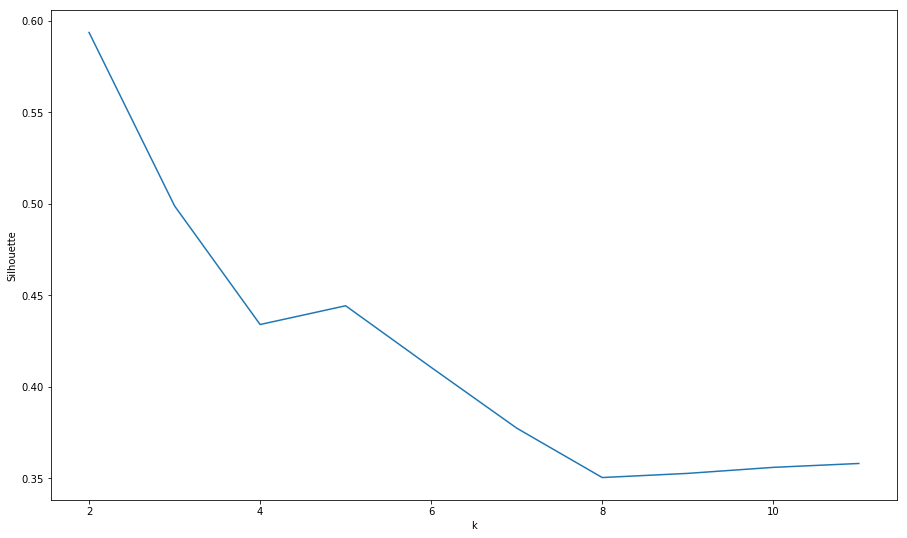

In [80]:
from scipy import cluster 
from sklearn import metrics
from sklearn.cluster import KMeans

#Elección de parámetro
X,Y = [],[]
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(2,12):
    kmeans_model = KMeans(n_clusters=i).fit(beer_red)
    labels = kmeans_model.labels_
    Y.append(metrics.silhouette_score(beer_red,labels,metric='euclidean'))
    X.append(i)

plt.xlabel('k')
plt.ylabel('Silhouette')
plt.plot(X,Y)
plt.show()

En la celda anterior, en pós de encontrar el *K* óptimo para K-means, se grafica el indicador de Silhouette para un k entre 2 y 11. Este indicador mide el grado de cohesión promedio dentro de  un cluster y grado de separación con el cluster más cercano. El indicador toma los valores entre [-1,1] , donde un valor cercano a 1 implica que el dato está bien unido a su cluster(centro) y pobremente unido con sus clusters vecinos, a su vez un valor cercano a -1 significa que hay muchos ó pocos clusters y no hay una división de cluster razonable.

En cuanto al gráfico,se observa una baja pronunciada en el indicador entre el intervalo [2,4] y [5,6], hay que tener en cuenta en tomar un 'K' que no sea muy restrictivo ni muy permisivo, es decir,no sería útil para un análisis tener 1 sólo cluster,tampoco así tener una cantidad de clusters en igual orden de magnitud que la cantidad de datos.Un valor posible y el adoptado es K=5, se aprecia que hay una leve subida del indicador y luego tiende a la baja.

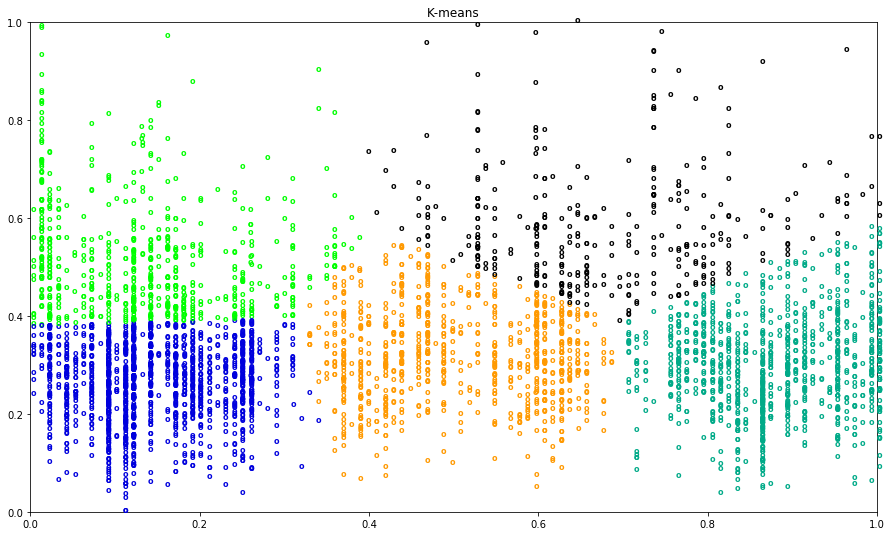

In [82]:
#Normalización para visualización:
x_min, x_max = np.min(beer_red, axis=0), np.max(beer_red, axis=0)
beer_red = (beer_red - x_min)/(x_max - x_min)
n_samples = beer_red.shape[0]
n_cl = 5
kmeans = KMeans(init='k-means++',n_clusters=n_cl)
kmeans.fit(beer_red)

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(n_samples):
    plt.text(beer_red[i,0], beer_red[i,1],'o',
    color=plt.cm.spectral(kmeans.labels_[i]/n_cl),
    fontdict={'weight': 'bold', 'size': 8})

plt.title("K-means")
plt.show()

Se normaliza la matriz y se ejecuta el algoritmo, se visualiza la manera en que k-means agrupa según un centroide,esto quiere decir, que no hay mezclas entre clusters.

**Minibatch K-MEANS**:

Es una variación del algoritmo de K-means que  usa pequeños lotes "mini-batches" de datos para correr k-means cuando la colección de datos es muy grande, busca escalar a K-Means. Se prefijan los tamaños de los batch y a la hora de recalcular los centroides se utilizan estos en vez de todo el dataset.

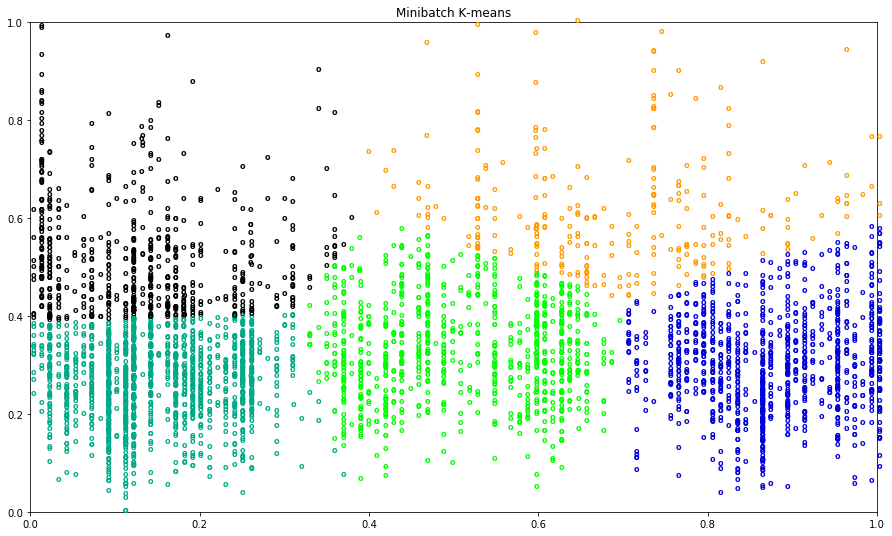

In [84]:
from sklearn.cluster import MiniBatchKMeans

mini_kmeans = MiniBatchKMeans(init='k-means++',batch_size=1000,n_clusters=5)
mini_kmeans.fit(beer_red)

x_min, x_max = np.min(beer_red, axis=0), np.max(beer_red, axis=0)
beer_red = (beer_red - x_min)/(x_max - x_min)
n_samples = beer_red.shape[0]

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(n_samples):
    plt.text(beer_red[i,0], beer_red[i,1],'o',
    color=plt.cm.spectral(mini_kmeans.labels_[i]/5),
    fontdict={'weight': 'bold', 'size': 8})

plt.title("Minibatch K-means")
plt.show()


La visualización de Minibatch K-means es casi isomorfa a K-means, ya que en sí utiliza el mismo principio. El 'casi' es ya que al ocupar porciones o mini batches de los datos originales, al recalcular los centroides puede que algunos datos se cambien del cluster a otro por el nuevo centro.

**HAC Complete**


Hierarchical Agglomerative Clustering, es un tipo de clustering 'glotón',parte de un cluster de un punto de tamaño y mediante un criterio de unión definido de distancia se va aglomerando a otro punto formando un cluster de tamaño 2, luego este cluster agrega a otro y así sucesivamente.Este HAC es *Complete*, en este criterio, se aglomeran los clusters donde máxima sea su distancia. Esto sigue una estructura jerárquica, dado que a cada unión se crea un cluster compuesto de muchos otros, para visualizar de mejor manera este principio se crea un dendrograma: 

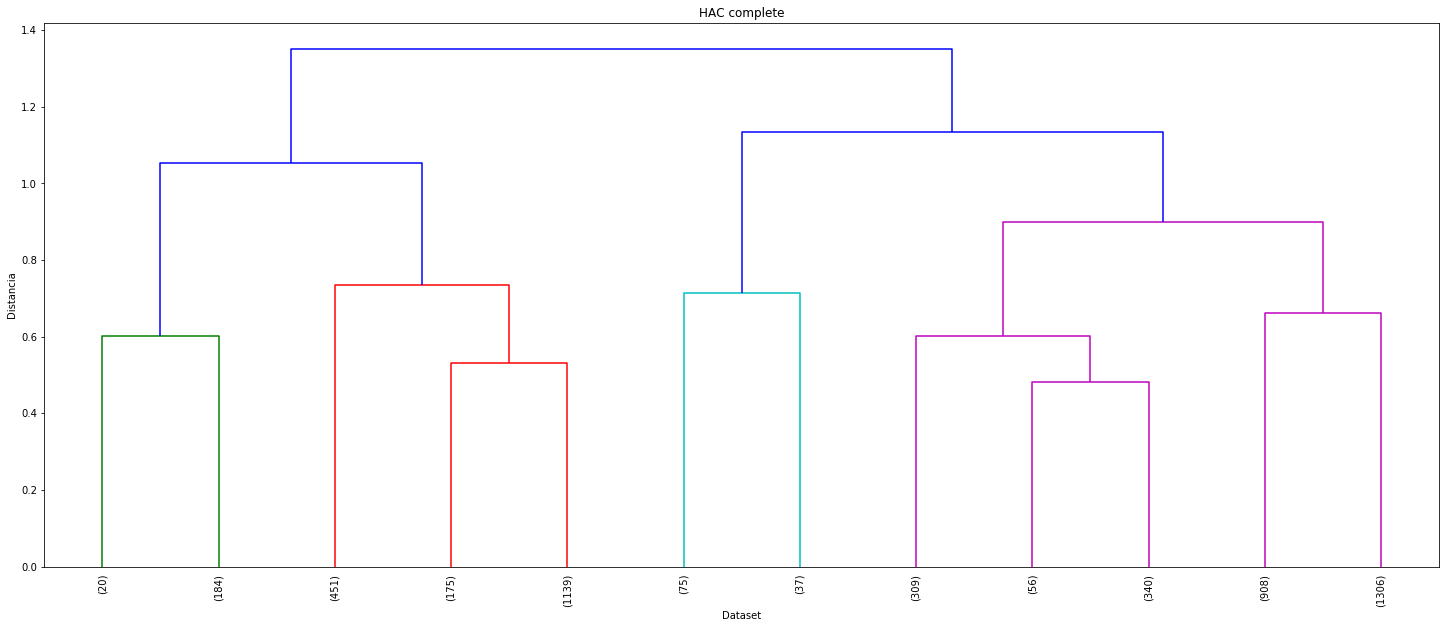

In [85]:
from scipy.cluster.hierarchy import dendrogram,linkage
Z = linkage(beer_red,'complete')

#Visualización en dendrograma
plt.figure(figsize=(25, 10))
plt.title('HAC complete')
plt.xlabel('Dataset')
plt.ylabel('Distancia')
dendrogram(
    Z,
    truncate_mode='lastp',  # Muestra las últimas 'p' uniones
    p=12,
    leaf_rotation=90.,   
    leaf_font_size=10.,  
)
plt.show()

En este dendrograma, se muestran las últimas 12 uniones por el hac. En el eje x están los 12 clusters de distintos tamaños antes de la unión final. La altura en las uniones entre clusters denota la distancia que hay entre ellos, la forma del dendrograma nos incita a cortar desde > 0,8 por la estructura que posee. Así un posible óptimo 'K' según este método es 4.

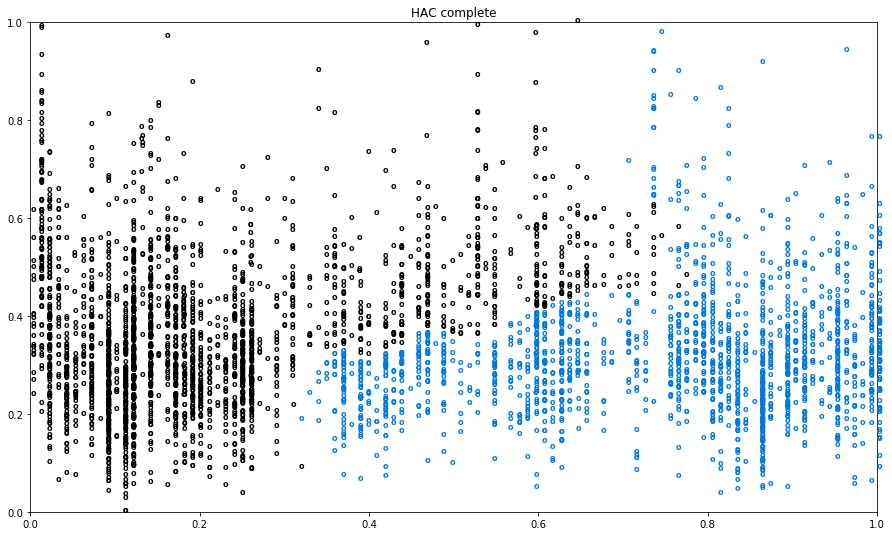

In [88]:
#Visualización 2D
from sklearn.cluster import AgglomerativeClustering as hac
hac = hac(linkage="complete",affinity="euclidean")
hac.fit(beer_red)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(n_samples):
	plt.text(beer_red[i,0], beer_red[i,1], 'o',
	color=plt.cm.spectral(hac.labels_[i]/4.),
	fontdict={'weight': 'bold', 'size': 8})

plt.title("HAC complete")
plt.show()


Una de las ventajas principales de estos algoritmos HAC es que determinan por su cuenta el 'k' óptimo en este caso k=2, contradiciendo nuestro supuesto que un k=4 sería idóneo. Se aprecia que a diferencia de los algoritmos k-means, hay mezclas más pronunciadas causadas por la naturaleza aglomerativa y jerárquica del algoritmo.

**Ward** 


Ward es una variante de HAC, en cada etapa, se unen los dos clusters
para los cuales se tenga el menor incremento en el valor total de la suma de los cuadrados de las diferencias,
dentro de cada cluster, de cada individuo al centroide del cluster.

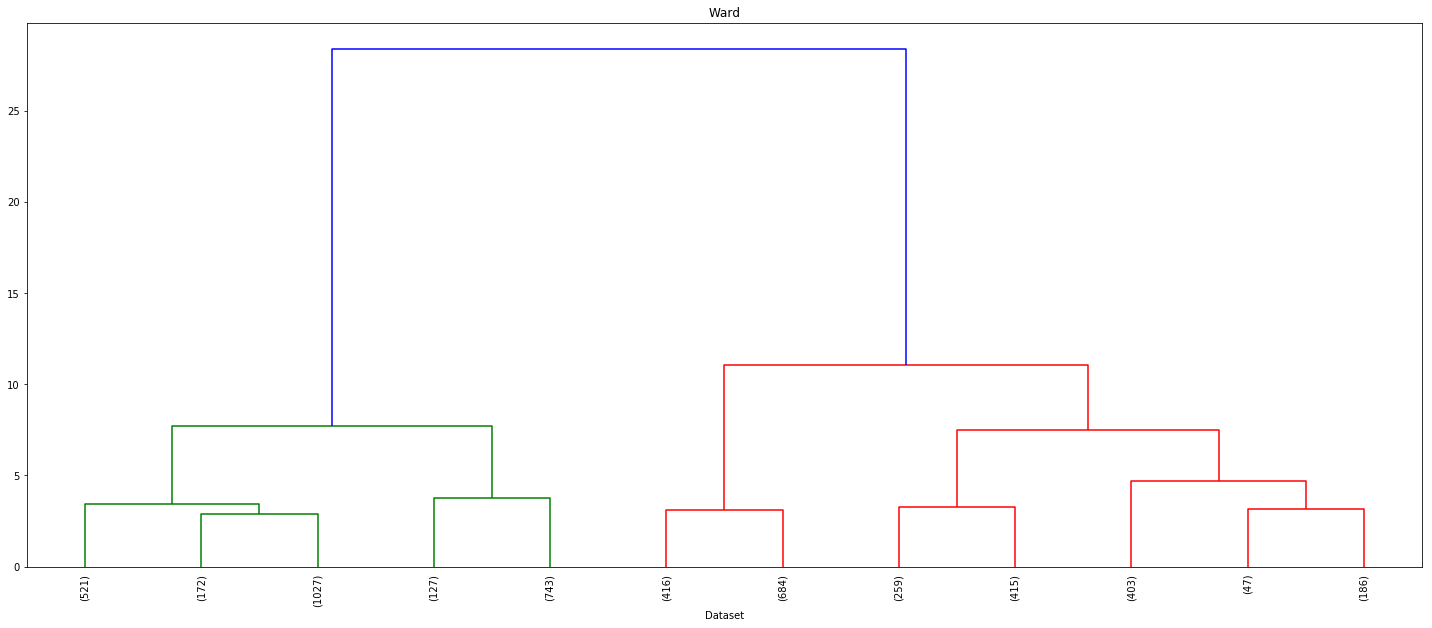

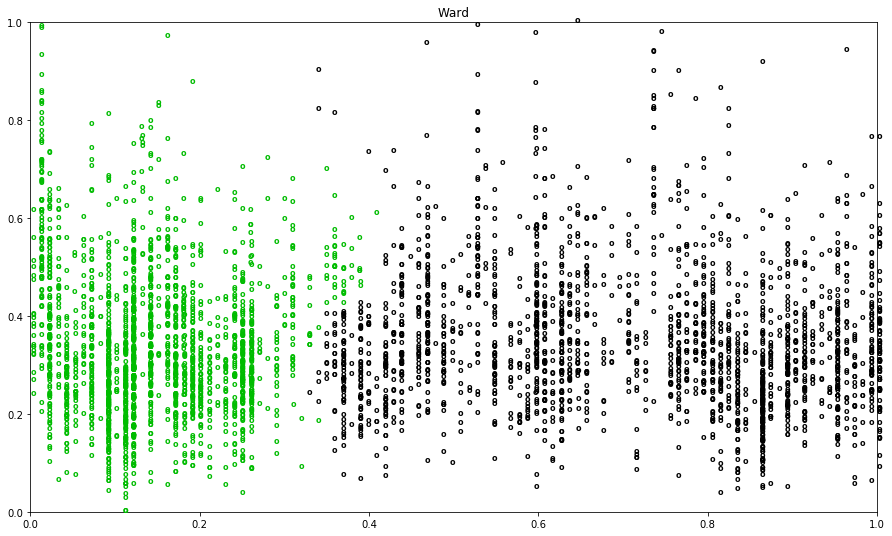

In [89]:
from scipy.cluster.hierarchy import dendrogram,linkage

Z = linkage(beer_red,'ward')

#Visualización en dendrograma
plt.figure(figsize=(25, 10))
plt.title('Ward')
plt.xlabel('Dataset')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=12,
    leaf_rotation=90.,  
    leaf_font_size=10., 
)
plt.show()

#Visualización en 2D:
from sklearn.cluster import AgglomerativeClustering as hac
hac = hac(linkage="ward", n_clusters=2, affinity="euclidean")
hac.fit(beer_red)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(n_samples):
	plt.text(beer_red[i,0], beer_red[i,1], 'o',
	color=plt.cm.spectral(hac.labels_[i]/2.),
	fontdict={'weight': 'bold', 'size': 8})
plt.title("Ward")
plt.show()


Tanto como HAC complete y HAC ward decidieron por un k=2. En este último HAC, era más evidente por el dendrograma que serían 2 por la gran distancia entre los últimos cluster que se juntaron. A diferencia del HAC complete, Ward dejó más desbalanceado un cluster en relación a tamaño por su criterio de mínimizar los errores cuadráticos.

**DBSCAN** 

Es un método de clustering basado en densidad,los dos parámetros principales es el EPS, es el radio máximo donde cada dato abarca a una cantidad MinPts de vecinos. Este algoritmo es muy sensible a sus parámetros, por ejemplo, si el EPS es muy grande, todos son vecinos de todos.Si EPS es muy pequeño, nadie es vecino de nadie.

/home/fabian/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


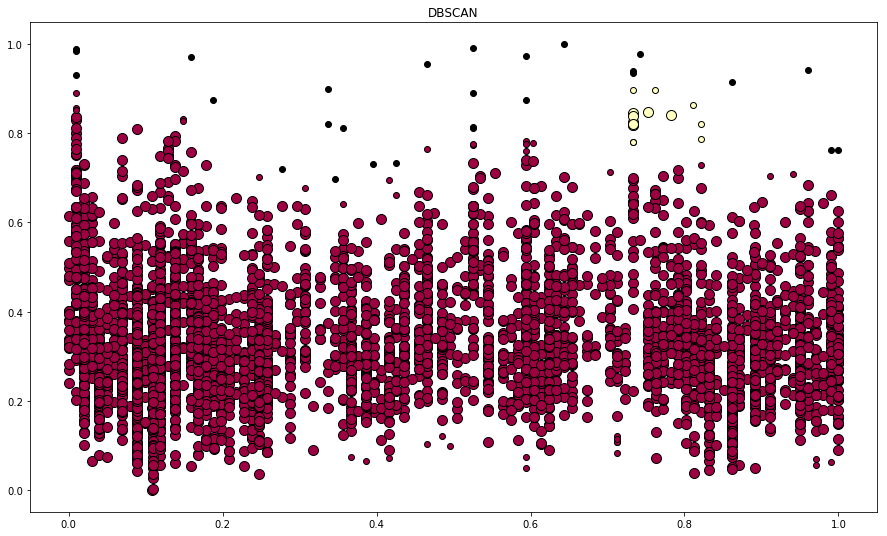

In [105]:
import numpy, scipy
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

db = DBSCAN(eps=0.07, min_samples=10).fit(beer_red)
core_samples_mask = numpy.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)
colors = plt.cm.Spectral(numpy.linspace(0, 1, len(unique_labels)))
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for k, col in zip(unique_labels, colors):
	if k == -1:
		col = 'k'
	class_member_mask = (labels == k)
	xy = beer_red[class_member_mask & core_samples_mask]
	plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
	xy = beer_red[class_member_mask & ~core_samples_mask]
	plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
    
plt.title("DBSCAN")
plt.show()

Por la densidad del grafo, es complejo obtener una cantidad razonable de clusters, dado que con un EP relativamente bajo ya toma toda la distribución de datos como 1 cluster. Sólo con un EP < 0.08 surge un cluster distinto al global, lo que indica la densidad de los datos de la matriz.

Nombre de cervecería o Tipo de Cerveza describe mejor a los cluster como etiquetas de clase?

In [1]:
#Que es más representativo
styless = set(beer_r['beer_style'])
print(len(styless))
print(list(beer_r.beer_style))
#print(len(set(le.inverse_transform(beer_r['beer_style']))))
#print(list(set(le.ransform(beer_r['beer_style']))))


NameError: name 'beer_r' is not defined

In [ ]:
Hay mejores marcas que otras en relación a las evaluaciones obtenidas?

Se puede definir algún criterio para determinar el mejor tipo de cerveza?
Ver promedio de clusters => ver el que tenga mayor promedio => analizar o ver q marcas o tipos de ceveza se repiten mas.
